In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/downloads'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import copy
import time
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import transformer_lens
import datasets
from load import *
from analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df
)
from activations.activation_subset import load_activation_subset, load_neuron_subset_csv
from analysis.plots import *

In [4]:
model_name = 'pythia-19m'
dataset_name = 'compound_words.pyth.16.-1'
experiment_name = 'activation_metrics_21299484'

act_subset_dict, metadata = load_activation_subset('results', model_name, dataset_name, experiment_name, 'activation_subsets')
feature_dataset = load_feature_dataset(dataset_name)
model = load_model('pythia-70m') # only need tokenizer so load smallest model

from argparse import Namespace
args = Namespace(model=model_name, neuron_subset_file='compound_words.csv')
neurons, ndf = load_neuron_subset_csv(args, return_df=True)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(
Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m into HookedTransformer


In [6]:
layer_ix = 1
neuron_ix = 111

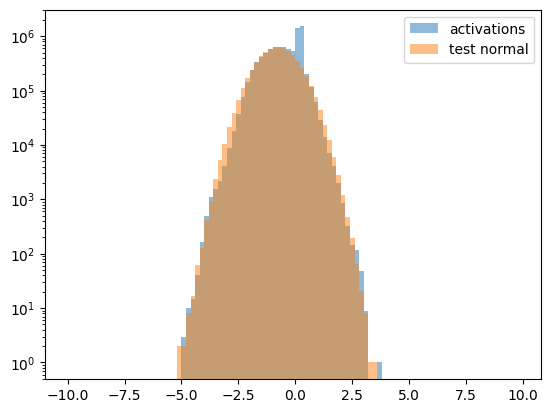

In [8]:
from activations.activation_metrics import load_activation_metrics
experiment_dir = 'results/full_activation_histogram/pythia-70m/distribution_id.pyth.512.-1/full_range'
top_k_seqix, top_k_pos, bin_counts, metadata = load_activation_metrics(experiment_dir)

hist_params = metadata['metrics_params']
bin_edges = torch.linspace(hist_params['hist_min'], hist_params['hist_max'], hist_params['n_bin']+1)


min_bin_ix = 450
max_bin_ix = 550

act_hist = bin_counts[layer_ix, neuron_ix, min_bin_ix:max_bin_ix-1].numpy()
plt.hist(bin_edges[min_bin_ix:max_bin_ix-1], bin_edges[min_bin_ix+1:max_bin_ix], weights=act_hist, label='activations', alpha=0.5);
#plt.hist(np.random.logistic(loc=-0.78, scale=0.35, size=act_hist.sum() - 2254530), bins=bin_edges[min_bin_ix:max_bin_ix], alpha=0.2, label='test logistic')
plt.hist(np.random.normal(loc=-0.78, scale=0.81, size=act_hist.sum() - 2254530), bins=bin_edges[min_bin_ix:max_bin_ix], alpha=0.5, label='test normal')

plt.yscale('log')
plt.legend()

In [4]:
model_name = 'pythia-70m'
dataset_name = 'pile_test.pyth.512.-1'
experiment_name = 'pyth70m_l1_n111'
act_subset_dict, metadata, token_summary_df = load_activation_subset('results', model_name, dataset_name, experiment_name, 'activation_subset')
feature_dataset = load_feature_dataset(dataset_name)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [11]:
activation_df

,token,activation
0,0,0.434082
1,1532,0.793945
2,187,0.283447
3,15834,0.201904
4,27,-0.302246
...,...,...
332293627,1288,-0.872070
332293628,723,-1.729492
332293629,441,-0.238159
332293630,281,-0.319092


In [5]:
activations = act_subset_dict[layer_ix, neuron_ix]

decoded_vocab = {t: model.tokenizer.decode(t) for t in model.tokenizer.get_vocab().values()}
activation_df = pd.DataFrame({
    'token': feature_dataset['tokens'].flatten().numpy().astype(np.uint16),
    'activation': activations.flatten().numpy().astype(np.float16),
    # 'string': [x for x in map(decoded_vocab.get, feature_dataset['tokens'].flatten().numpy())]
})
# activation_df['preceding_token'] = activation_df['token'].shift(1).fillna(0).astype(int)



NameError: name 'layer_ix' is not defined

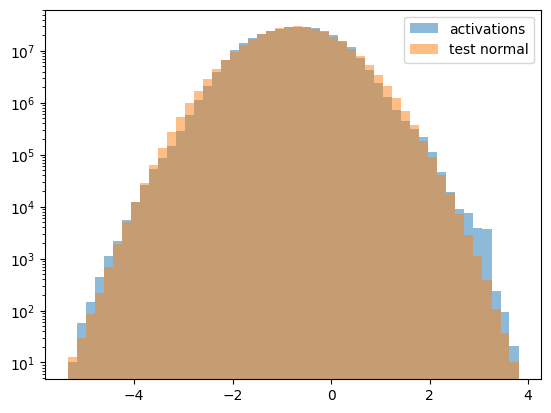

In [461]:
c, bins, ax = plt.hist(activation_df['activation'], bins=50, alpha=0.5, label='activations')
plt.hist(np.random.normal(loc=-0.73, scale=0.82, size=len(activation_df['activation'])), bins=bins, alpha=0.5, label='test normal');
plt.legend()
plt.yscale('log')


In [12]:
(1 - (activation_df['activation'] > 2).mean()) * 100

99.94509374167002

In [12]:
(activation_df.memory_usage() / 2**30).round(2)

Index         0.00
token         0.62
activation    0.62
dtype: float64

In [15]:
token_summary_df['upper_quartile_range'] = token_summary_df['max'] - token_summary_df['75%']

In [6]:
np.corrcoef(token_summary_df['mean'].values, token_summary_df['max'].values)

array([[1.        , 0.82785114],
       [0.82785114, 1.        ]])

Text(0, 0.5, 'upper quartile range')

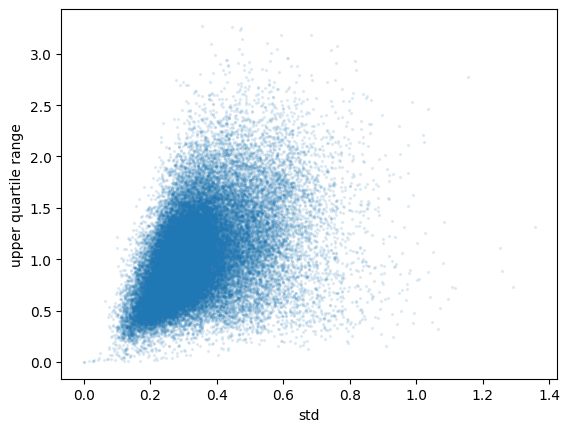

In [18]:
plt.scatter(token_summary_df['std'], token_summary_df['upper_quartile_range'], alpha=0.1, s=2)
plt.xlabel('std')
plt.ylabel('upper quartile range')

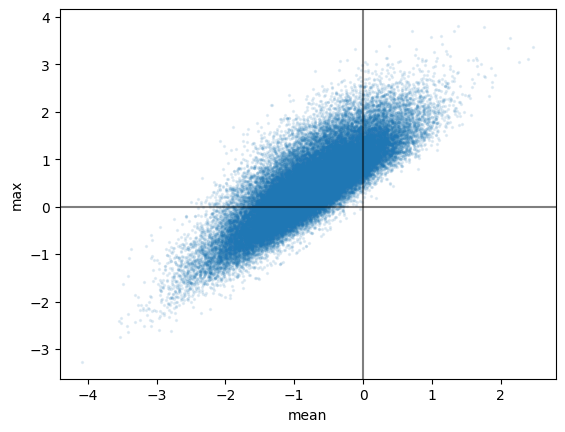

In [19]:
plt.scatter(token_summary_df['mean'], token_summary_df['max'], alpha=0.1, s=2)
plt.xlabel('mean')
plt.ylabel('max')
plt.axvline(0, color='black', alpha=0.5)
plt.axhline(0, color='black', alpha=0.5)

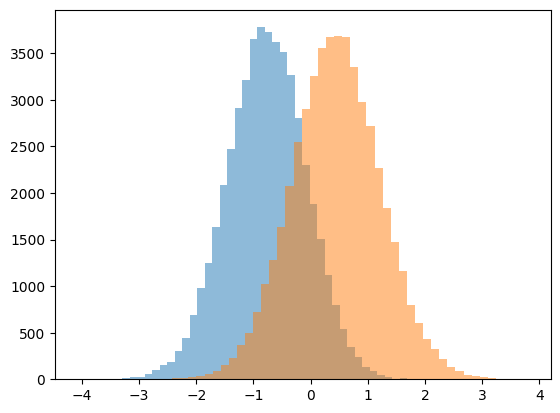

In [20]:
plt.hist(token_summary_df['mean'], bins=50, alpha=0.5) 
plt.hist(token_summary_df['max'], bins=50, alpha=0.5);

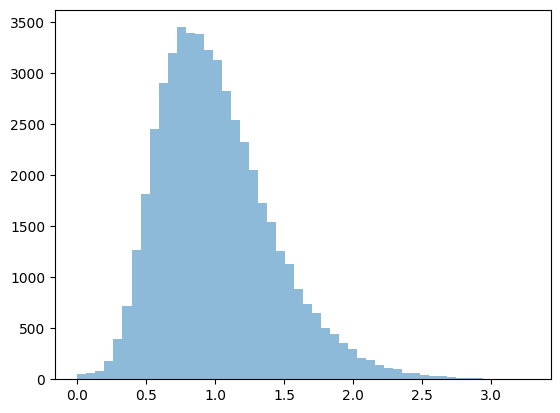

In [21]:
plt.hist(token_summary_df['upper_quartile_range'], bins=50, alpha=0.5);

In [7]:
token_summary_df.sort_values('max', ascending=False).head(20)

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string
10150,1,111,10231,5406.0,1.377443,0.460696,0.173815,1.074171,1.345718,1.612933,3.807569,Young
18722,1,111,18848,1995.0,1.755164,0.589312,0.171141,1.367463,1.612594,2.052914,3.786464,rob
13511,1,111,13606,1852.0,0.710175,0.487424,-0.641478,0.481511,0.742353,0.932164,3.701391,oven
238,1,111,248,38032.0,1.324904,0.540824,-0.879390,1.053629,1.348520,1.593599,3.691401,he
35283,1,111,35476,761.0,1.138903,1.259490,-0.407308,0.091886,0.434587,2.711395,3.598499,Boost
2270,1,111,2302,45384.0,0.987751,0.499092,-0.182864,0.619761,0.910697,1.234863,3.574919,No
2311,1,111,2343,10009.0,2.128946,0.452834,0.676105,1.794318,2.128844,2.475237,3.556151,lo
2582,1,111,2616,37129.0,1.144782,1.020941,-0.472942,0.478468,0.695881,1.220461,3.434135,factors
6815,1,111,6875,9558.0,0.379560,0.775720,-1.489540,-0.172560,0.147484,0.735948,3.394442,Science
14792,1,111,14895,2618.0,2.472256,0.609462,0.749957,1.839423,2.770393,3.022200,3.368722,)*-


In [127]:
is_alphabetical = [
    all(c.isalpha() or c.isspace() for c in t_str) 
    if isinstance(t_str, str) else False 
    for t_str in token_summary_df['string'].values
]

token_summary_df['is_alphabetical'] = is_alphabetical

# Most interested in tokens with high max and either high variance or high upper quartile range
max_activating = token_summary_df.query('(count > 10) and is_alphabetical').sort_values('max', ascending=False).head(250)
max_std_tokens = max_activating.sort_values(('std'), ascending=False).head(25).token.values
max_quartile_range_tokens = max_activating.sort_values(('upper_quartile_range'), ascending=False).head(25).token.values
interesting_tokens = set(max_std_tokens) | set(max_quartile_range_tokens)

tokens_of_interest_df = token_summary_df.query('token in @interesting_tokens')
tokens_of_interest_df.sort_values('max', ascending=False)

,layer,neuron,token,count,mean,std,min,25%,50%,75%,max,string,upper_quartile_range,is_alphabetical
13511,1,111,13606,1852.0,0.710175,0.487424,-0.641478,0.481511,0.742353,0.932164,3.701391,oven,2.769227,True
35283,1,111,35476,761.0,1.138903,1.259490,-0.407308,0.091886,0.434587,2.711395,3.598499,Boost,0.887104,True
2582,1,111,2616,37129.0,1.144782,1.020941,-0.472942,0.478468,0.695881,1.220461,3.434135,factors,2.213673,True
6815,1,111,6875,9558.0,0.379560,0.775720,-1.489540,-0.172560,0.147484,0.735948,3.394442,Science,2.658494,True
15249,1,111,15353,2944.0,-0.114517,0.469674,-1.301051,-0.382378,-0.159910,0.090193,3.317993,gate,3.227800,True
2515,1,111,2548,32526.0,0.192109,0.464997,-1.015277,-0.115713,0.081308,0.365900,3.273497,Type,2.907597,True
48606,1,111,48862,474.0,1.026818,1.083353,-0.838725,0.219836,0.544651,1.905704,3.264276,AUX,1.358572,True
17509,1,111,17629,1353.0,0.340778,1.154727,-1.208355,-0.365566,-0.154485,0.345725,3.124212,ograms,2.778487,True
398,1,111,412,38263.0,-0.235358,0.614055,-2.232648,-0.662722,-0.266858,0.145085,3.099788,op,2.954702,True
19871,1,111,20000,2441.0,-0.341707,0.474780,-1.419058,-0.655740,-0.399529,-0.068716,3.071229,Peace,3.139945,True


In [41]:


def print_minmax_activations_for_token(token, activation_df, feature_dataset, model,
     print_n_tokens_before=3, print_n_tokens_after=5, top_k=10, bottom_k=10):
    t_str = model.tokenizer.decode(token)
    n_seqs, n_pos = feature_dataset['tokens'].shape
    print(f'########### Activations for {token}: "{t_str}" ###########')
    max_activating = activation_df.query('token==@token').sort_values('activation', ascending=False).head(top_k)
    min_activating = activation_df.query('token==@token').sort_values('activation').head(bottom_k)

    print(f'### Max activations for {token}: "{t_str}" ###')
    for s, p in zip((max_activating.index.values // n_pos).tolist(), 
                    (max_activating.index.values % n_pos).tolist()):
        prefix = model.tokenizer.decode(feature_dataset[s]['tokens'][p-print_n_tokens_before:p])
        suffix = model.tokenizer.decode(feature_dataset[s]['tokens'][p+1:p+print_n_tokens_after])
        print(f'BEGIN ({activations[s, p]}): {prefix}|{t_str}|{suffix}')

    print(f'### Min activations for {token}: "{t_str}" ###')
    for s, p in zip((min_activating.index.values // n_pos).tolist(), 
                    (min_activating.index.values % n_pos).tolist()):
        prefix = model.tokenizer.decode(feature_dataset[s]['tokens'][p-print_n_tokens_before:p])
        suffix = model.tokenizer.decode(feature_dataset[s]['tokens'][p+1:p+print_n_tokens_after])
        print(f'BEGIN ({activations[s, p]}): {prefix}|{t_str}|{suffix}')

for ix, token in enumerate(np.array(list(interesting_tokens)).astype(np.uint16)):
    print_minmax_activations_for_token(token, activation_df, feature_dataset, model, 6, 2, 5, 5)


    

########### Activations for 20740: " census" ###########
### Max activations for 20740: " census" ###
BEGIN (3.064453125): , Iran. At the 2006| census|,
BEGIN (3.033203125): , Iran. At the 2006| census|,
BEGIN (3.02734375): , Iran. At the 2006| census|,
BEGIN (3.009765625): , Iran. At the 2006| census|,
BEGIN (3.0078125): , Iran. At the 2006| census|,
### Min activations for 20740: " census" ###
BEGIN (-0.50439453125):  four levels; 3) input| census| tract
BEGIN (-0.489501953125):  you don't fill out your| census| by
BEGIN (-0.45751953125): 

After "scouring| census| records
BEGIN (-0.430908203125):  then had all of his top| census| administrators
BEGIN (-0.3671875):  and known population size, usually| census| enumeration
########### Activations for 11: "*" ###########
### Max activations for 11: "*" ###
BEGIN (2.908203125): (s). Calculate -3|*|p
BEGIN (2.69921875):  + 1. Determine -5|*|a
BEGIN (2.67578125): d(c) + 2|*|w
BEGIN (2.669921875): k + 44. Calculate 2|*|g
BEGIN (2.666015625)

In [128]:
bigram_dfs = {}
for t in list(interesting_tokens):
    start_t = time.time()
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values
    bigram_df = t_adf.groupby('prefix').activation.describe().query('count > 2').sort_values('max', ascending=False).head(10)
    bigram_dfs[t] = bigram_df
    print(f'Finished processing token {t} in {time.time() - start_t:.2f} seconds ({len(t_adf)} occurrences)')
    
top_bigram_df = pd.concat(bigram_dfs)
top_bigram_df.index.names = ['suffix', 'prefix']
top_bigram_df['prefix_str'] = [f"'{decoded_vocab[p]}'" for p in top_bigram_df.index.get_level_values('prefix')]
top_bigram_df['suffix_str'] = [f"'{decoded_vocab[s]}'" for s in top_bigram_df.index.get_level_values('suffix')]



Finished processing token 20740 in 1.83 seconds (1913 occurrences)
Finished processing token 12299 in 1.59 seconds (716 occurrences)
Finished processing token 47117 in 1.67 seconds (480 occurrences)
Finished processing token 35476 in 1.68 seconds (761 occurrences)
Finished processing token 10518 in 2.25 seconds (4701 occurrences)
Finished processing token 26268 in 1.62 seconds (803 occurrences)
Finished processing token 412 in 2.88 seconds (38263 occurrences)
Finished processing token 20000 in 1.82 seconds (2441 occurrences)
Finished processing token 3621 in 1.56 seconds (383 occurrences)
Finished processing token 13606 in 1.59 seconds (1852 occurrences)
Finished processing token 423 in 2.56 seconds (93077 occurrences)
Finished processing token 5417 in 2.96 seconds (10407 occurrences)
Finished processing token 10668 in 2.52 seconds (5948 occurrences)
Finished processing token 14894 in 1.56 seconds (839 occurrences)
Finished processing token 10548 in 1.73 seconds (1913 occurrences)
Fini

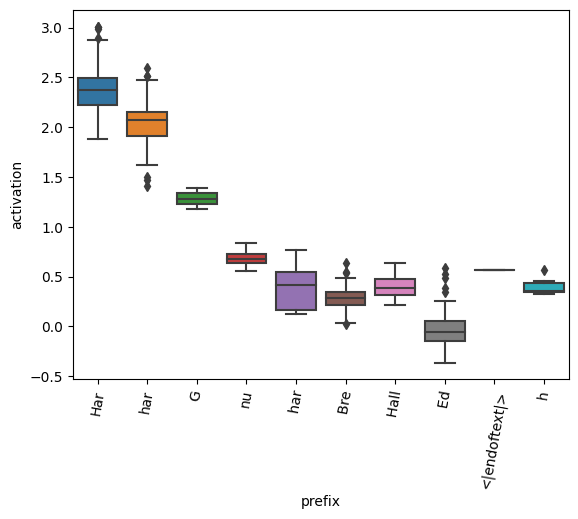

In [129]:
token = 12299
bigram_df = bigram_dfs[token]

t_adf = copy.deepcopy(activation_df.query('token==@token'))
t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values

valid_prefix_tokens = set(bigram_dfs[token].index.values)
token_strs = [decoded_vocab[t] for t in valid_prefix_tokens]

ax = sns.boxplot(t_adf, x='prefix', y='activation', order=bigram_dfs[token].index.values)
ax.set_xticklabels([decoded_vocab[int(t.get_text())].replace('$', '\$') for t in ax.get_xticklabels()], rotation=80);

/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_60716/297545264.py:18: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


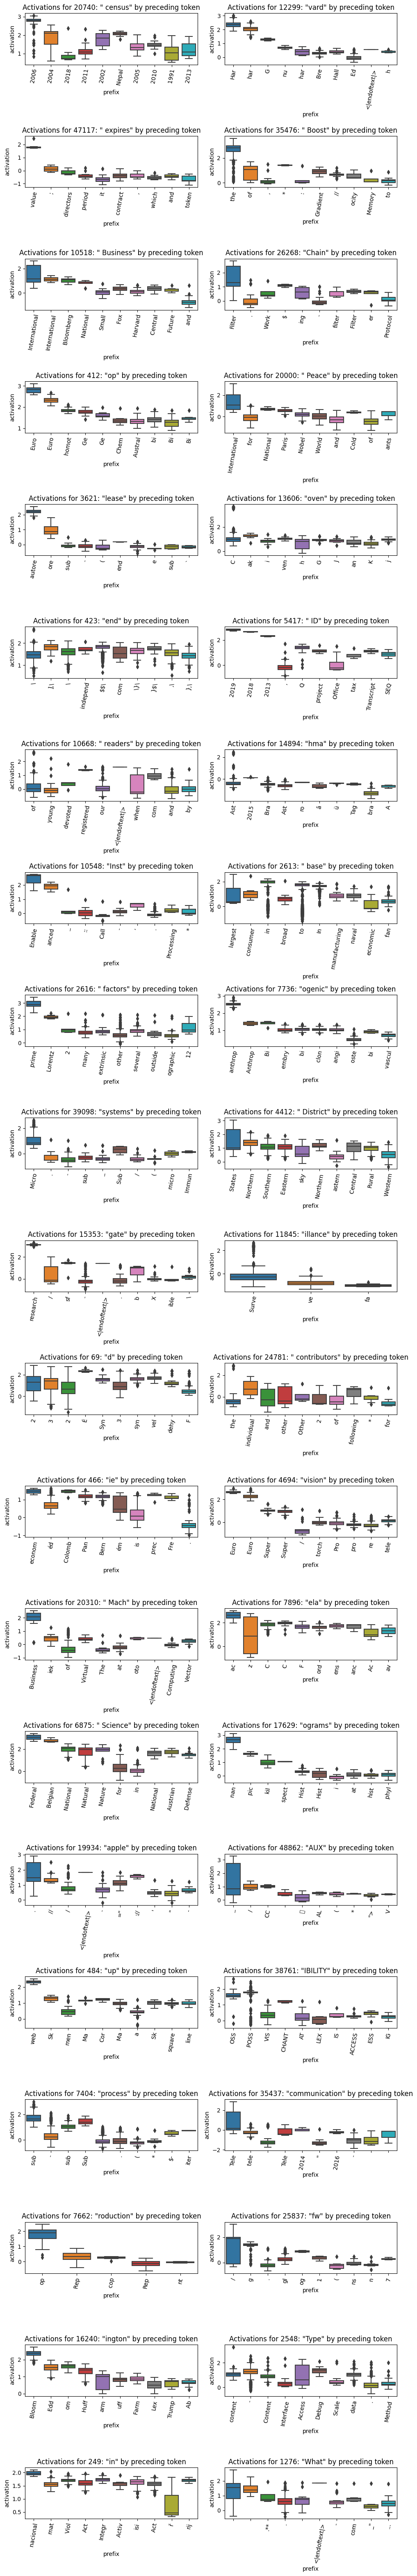

In [130]:
cols = 2
rows = math.ceil(len(interesting_tokens) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
for ix, token in enumerate(interesting_tokens):

    bigram_df = bigram_dfs[token]

    t_adf = copy.deepcopy(activation_df.query('token==@token'))
    t_adf['prefix'] = activation_df.loc[t_adf.index.values - 1, 'token'].values

    valid_prefix_tokens = set(bigram_dfs[token].index.values)
    token_strs = [decoded_vocab[t] for t in valid_prefix_tokens]

    ax = axes[ix//2, ix%2]
    sns.boxplot(t_adf, x='prefix', y='activation', order=bigram_dfs[token].index.values, ax=ax)
    ax.set_xticklabels([decoded_vocab[int(t.get_text())].replace('$', '\$') for t in ax.get_xticklabels()], rotation=80);
    ax.set_title(f'Activations for {token}: "{decoded_vocab[token]}" by preceding token')
plt.tight_layout()

In [132]:
bigram_dfs[47117]

,count,mean,std,min,25%,50%,75%,max
prefix,,,,,,,,
1318,7.0,1.864258,0.270508,1.702148,1.742676,1.774414,1.807129,2.470703
28,13.0,0.131714,0.188843,-0.135132,-0.037964,0.109680,0.291016,0.408203
17970,3.0,-0.114929,0.286377,-0.317627,-0.278748,-0.239868,-0.013550,0.212769
2180,15.0,-0.391113,0.227295,-0.630371,-0.524414,-0.455078,-0.325928,0.211182
352,29.0,-0.655273,0.249512,-1.082031,-0.821777,-0.681641,-0.561035,0.156128
3310,26.0,-0.392822,0.218262,-0.795898,-0.543945,-0.395996,-0.265930,0.146240
13,11.0,-0.392334,0.185791,-0.632812,-0.525635,-0.476318,-0.273804,-0.005703
534,10.0,-0.521484,0.163330,-0.719238,-0.631348,-0.542236,-0.453857,-0.181763
285,9.0,-0.449707,0.142700,-0.718750,-0.519531,-0.455078,-0.340576,-0.234131


In [187]:

def make_ngram_adf(activation_df, t, n_gram=4):
    col_names = [f'prefix-{i}' for i in range(n_gram-1, 0, -1)]
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    for i in range(n_gram-1, 0, -1):
        t_adf[f'prefix-{i}'] = activation_df.loc[t_adf.index.values - i, 'token'].values
    ngram_adf = t_adf.groupby(col_names).activation.describe().query('count > 2').sort_values('max', ascending=False).head(10)
    ngram_adf['string'] = [
        f"{', '.join([decoded_vocab[p] for p in ngram])}" 
        if isinstance(ngram, tuple) else decoded_vocab[ngram] 
        for ngram in ngram_adf.index.values]
    return ngram_adf

In [389]:
t = 19934

In [390]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=2)
ngram_adf

,count,mean,std,min,25%,50%,75%,max,string
prefix-1,,,,,,,,,
15,619.0,1.679688,0.667480,0.259521,1.243652,1.473633,2.486328,2.904297,.
605,69.0,1.341797,0.237915,1.134766,1.196289,1.231445,1.436523,2.517578,//
16,83.0,0.843262,0.390381,0.398682,0.598633,0.704102,0.890381,2.261719,/
0,5.0,1.840820,0.000000,1.839844,1.839844,1.839844,1.839844,1.839844,<|endoftext|>
14,111.0,0.678711,0.279541,-0.177124,0.518921,0.697266,0.810303,1.836914,-
568,109.0,1.124023,0.240356,0.614258,0.994141,1.107422,1.295898,1.820312,"="""
1358,6.0,1.573242,0.112488,1.394531,1.515381,1.600586,1.637451,1.705078,://
686,22.0,0.502441,0.217896,0.233276,0.400085,0.471313,0.564819,1.306641,'
346,38.0,0.432861,0.288574,-0.190430,0.290039,0.409668,0.583984,1.262695,""""


In [391]:
ngram_adf.index.values[:4]

array([ 15, 605,  16,   0], dtype=uint64)

In [392]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=3)
ngram_adf

,,count,mean,std,min,25%,50%,75%,max,string
prefix-2,prefix-1,,,,,,,,,
35654,15,78.0,2.751953,0.070618,2.591797,2.708984,2.748047,2.790527,2.904297,"developer, ."
2700,15,94.0,2.212891,0.567871,1.092773,1.596436,2.512695,2.583496,2.828125,"www, ."
681,15,247.0,1.544922,0.416260,0.627930,1.354492,1.456055,1.769531,2.605469,"com, ."
4,605,14.0,1.727539,0.257080,1.436523,1.613525,1.720703,1.763672,2.517578,"#, //"
28047,15,4.0,2.027344,0.302979,1.637695,1.913818,2.050781,2.164551,2.371094,"apps, ."
1505,15,17.0,1.503906,0.209595,1.094727,1.433594,1.450195,1.506836,2.111328,"ource, ."
11618,15,4.0,1.746094,0.142944,1.632812,1.674561,1.697754,1.769043,1.955078,"vm, ."
14124,15,31.0,1.351562,0.269775,0.556641,1.251953,1.336914,1.516602,1.907227,"unes, ."
78,15,37.0,1.374023,0.157715,1.093750,1.267578,1.313477,1.495117,1.855469,"m, ."


In [393]:
ngram_adf.index.values[:3]

array([(35654, 15), (2700, 15), (681, 15)], dtype=object)

In [377]:
ngram_adf = make_ngram_adf(activation_df, t, n_gram=4)
ngram_adf

,,,count,mean,std,min,25%,50%,75%,max,string
prefix-3,prefix-2,prefix-1,,,,,,,,,
43950,762,253,120.0,3.052734,0.171143,2.292969,2.964844,3.013672,3.109863,3.597656,"Distributed, under, the"
3567,762,253,115.0,2.734375,0.139038,2.412109,2.625000,2.785156,2.837891,3.048828,"ributed, under, the"
2256,281,253,39.0,1.654297,0.270020,0.909180,1.589355,1.709961,1.794922,2.111328,"subject, to, the"
605,41371,273,7.0,1.458984,0.209473,1.230469,1.264648,1.444336,1.660156,1.689453,"//, Parts, of"
30,1186,49361,5.0,0.981445,0.223267,0.670898,0.912598,0.964355,1.078125,1.279297,"=, , Gradient"
10367,22484,23716,3.0,0.602051,0.382324,0.375732,0.381592,0.387451,0.715820,1.043945,"mal, Vel, ocity"
18296,285,21688,3.0,0.374023,0.517090,0.067444,0.075623,0.083801,0.527588,0.971191,"Mind, and, Memory"
31,187,605,3.0,0.782715,0.166504,0.655273,0.688477,0.721680,0.846436,0.971191,">, \n, //"
1797,186,3122,3.0,0.177368,0.484863,-0.134033,-0.102020,-0.070007,0.333252,0.736328,"21, \t, /*"


In [380]:
ngram_adf.index.values[:3]

array([(43950, 762, 253), (3567, 762, 253), (2256, 281, 253)],
      dtype=object)

In [456]:
# token_ix: [list of prefixes to create classes for]
# each list containts a set of prefixes
# where a prefix is a tuple of tokens
neuron_stimuli = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]], # census
    26268: [[(15, 12332, 9824)], [(32170, 9824)]], # Chain d
    412: [[(47678, ), (14029, )]], # op
    20000: [[(38476, 5625)]], # Peace
    3621: [[(47694, )]], # lease
    13606: [[(5625, 330)]], # oven
    14894: [[(12602, 273, 15123)]], # hma
    2616: [[(4335, )], [(29602, )]], # factors d
    7736: [[(21698, )]], # pogenic
    39098: [[(4146, 12761), (14594, 12761)]], # systems
    4412: [[(11586, 2077)]], # District
    15353: [[(36642, )]], # gate
    11845: [[(19256, 38056)]], # iallance
    4694: [[(47678, ), (14029, )]], # vision 
    20310: [[(5625, 10518), (22817, 10518)]], # Mach
    6875: [[(7671, ), (31351, )]], # Science
    17629: [[(6399, )]], # ograms
    19934: [[(35654, 15)], [(2700, 15)]], # apple , 
    48862: [[(45590, 64)]], # AUX
    7404: [[(749, ), (2377, )]], # process
    35437: [[(22817, 13940), (5625, 13940)]], # communication
    7662: [[(2359, 412), (22468, 412)]], # roduction
    25837: [[(681, 16)]], # fw
    16240: [[(21034, )], [(20709, )]], # ington d
}

In [364]:
t = 16240

# for prefix in neuron_stimuli[t][0]:
#     print(' '.join([decoded_vocab[p] for p in prefix]))

In [453]:
neuron_stimuli = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]], # census
}

In [457]:
stimuli_order = token_summary_df.loc[token_summary_df.token.isin(neuron_stimuli.keys())].sort_values('max', ascending=False).token.values

Text(0.5, 1, 'Activation distribution of neuron 1.111 by token colored by prefix')

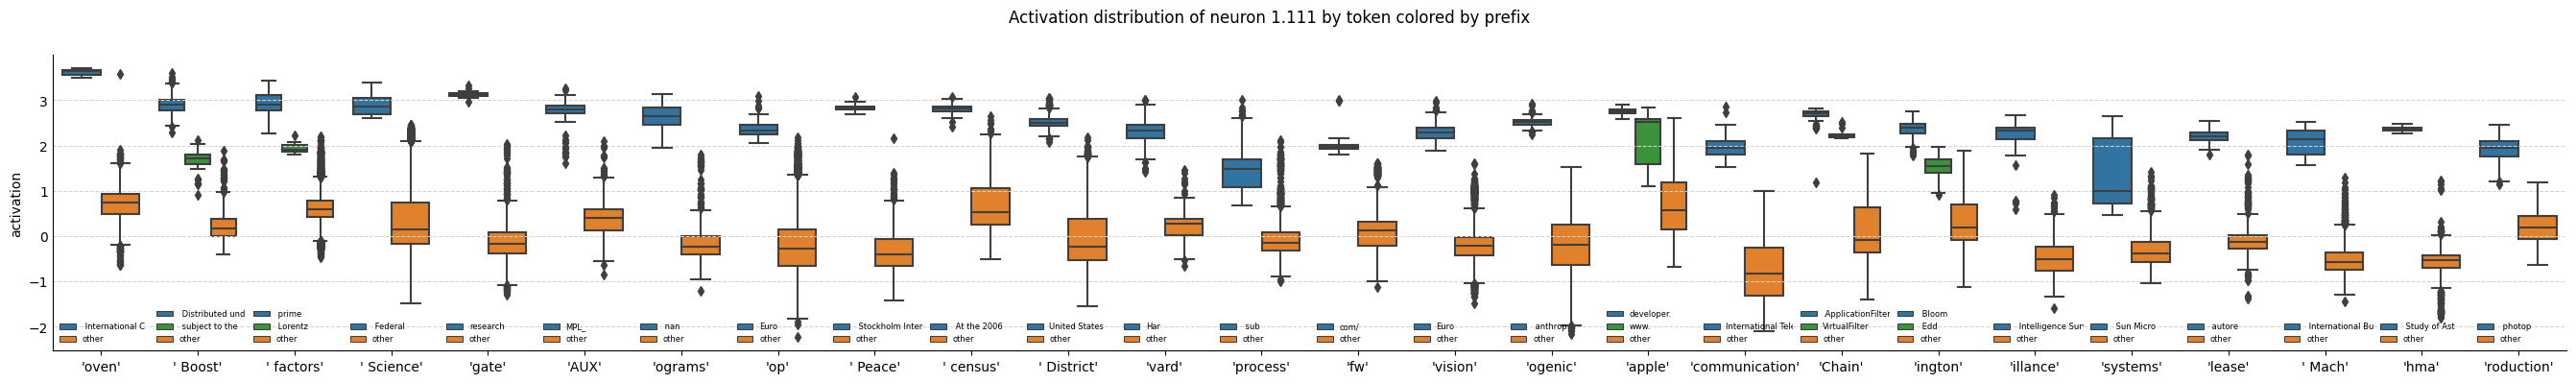

In [459]:
fig, axs = plt.subplots(1, len(neuron_stimuli), figsize=(1.3 * len(neuron_stimuli), 4), sharey=True)
order_priorities = []
for ix, t in enumerate(stimuli_order):
    t_adf = copy.deepcopy(activation_df.query('token==@t'))
    t_adf['class_label'] = 'other'  # start with other by default
    stimulus_order = []
    for stimulus in neuron_stimuli[t]:
        n_gram = max(len(p) for p in stimulus)
        for i in range(n_gram, 0, -1):
            t_adf[f'prefix-{i}'] = activation_df.loc[t_adf.index.values - i, 'token'].values

        # use first prefix in the set as class label
        stimulus_string =  f"{''.join([decoded_vocab[p] for p in stimulus[0]])}" 
        stimulus_order.append(stimulus_string)

        for prefix in stimulus:
            if len(prefix) == 1:
                t_adf.loc[t_adf['prefix-1'] == prefix[0], 'class_label'] = stimulus_string
            elif len(prefix) == 2:
                t_adf.loc[
                    (t_adf['prefix-2'] == prefix[0]) & 
                    (t_adf['prefix-1'] == prefix[1]), 
                    'class_label'
                ] = stimulus_string
            elif len(prefix) == 3:
                t_adf.loc[
                    (t_adf['prefix-3'] == prefix[0]) & 
                    (t_adf['prefix-2'] == prefix[1]) & 
                    (t_adf['prefix-1'] == prefix[2]), 
                    'class_label'
                ] = stimulus_string
            else:
                raise ValueError(f"prefix length {len(prefix)} not supported")

    # used to reorder the subplots after plotting
    max_class_median_activation = t_adf.groupby('class_label').activation.median().max()
    order_priorities.append(max_class_median_activation)

    stimulus_order.append('other')
    # see https://stackoverflow.com/questions/46173419/seaborn-change-color-according-to-hue-name
    # always want orange to be the last color
    palette = ["C0", "C2", "C1"] if len(stimulus_order) == 3 else ["C0", "C1"]
    ax = axs[ix]
    sns.boxplot(
        t_adf, x='token', y='activation', hue='class_label', 
        hue_order=stimulus_order, palette=palette, ax=ax
    )
    ax.legend(loc='lower left', prop={'size': 6}, frameon=False)

    # formatting
    ax.set_xlabel('')
    ax.set_xticklabels([f"'{decoded_vocab[t]}'"])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.75)
    ax.tick_params(axis='y', which='both', length=0)
    if ix > 0:
        ax.set_ylabel('')
        ax.spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

# reorder subplots by order_priorities
# subplot_permutation = np.argsort(np.array(order_priorities))[::-1]
# new_positions = {ax_ix: axs[top_ix].get_position() for ax_ix, top_ix in enumerate(subplot_permutation)}
# for ax_ix, top_ix_plot_position in new_positions.items():
#     axs[ax_ix].set_position(top_ix_plot_position)

plt.suptitle('Activation distribution of neuron 1.111 by token colored by prefix', y=1)

In [ ]:
# Make title larger

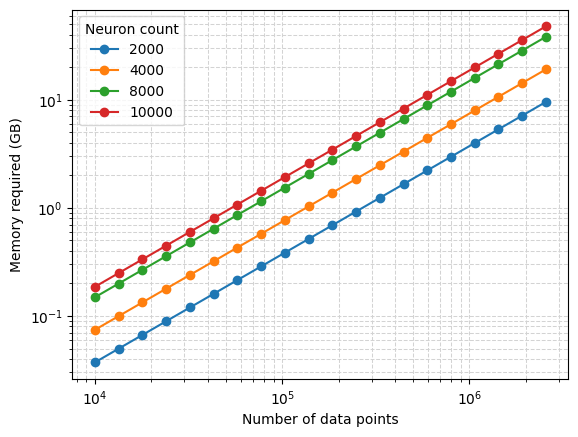

In [473]:
n_neurons = [2000, 4000, 8000, 10000]
n_data_points = 10_000 * 2 ** np.linspace(0, 8, 20)
for n in n_neurons:
    plt.plot(n_data_points, (n_data_points * n * 2) / 2**30, label=n, marker='o')
plt.legend(title='Neuron count')
plt.xlabel('Number of data points')
plt.ylabel('Memory required (GB)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', axis='both', color='lightgray', linestyle='--', linewidth=0.75)

In [469]:
10_000 * 2 ** np.linspace(0, 8, 20)

array([  10000.        ,   13389.04101224,   17926.64192276,
         24002.05439156,   32136.44906268,   43027.62344881,
         57609.86150155,   77134.0798354 ,  103275.13583579,
        138275.50292506,  185137.63796524,  247881.54276266,
        331889.61422278,  444368.36563669,  594966.62720538,
        796603.25725698, 1066575.36819014, 1428042.13473478,
       1912011.47091774, 2560000.        ])

In [174]:
print_minmax_activations_for_token(80, activation_df, feature_dataset, model, top_k=50)

########### Activations for 80: "o" ###########
### Max activations for 80: "o" ###
BEGIN (2.689453125): ], the magnet|o|elastic anisotropy along \[
BEGIN (2.671875):  exhibits the magnet|o|-electric effect,
BEGIN (2.6640625):  scaling of magnet|o|-transport, with
BEGIN (2.626953125):  on the magnet|o|-hydrodynamics simulations
BEGIN (2.59765625):  of strong magnet|o|-elastic coupling in
BEGIN (2.58984375):  using a magnet|o|-optical storage medium
BEGIN (2.583984375):  a large magnet|o|-optical trap (
BEGIN (2.576171875):  classical anisotropic magnet|o|-resistance phenomena,
BEGIN (2.560546875): ography, magnet|o|encephalography, near
BEGIN (2.55859375):  the continuum magnet|o|-mechanics
BEGIN (2.529296875):  origin of magnet|o|-oscillations
BEGIN (2.521484375):  lowers the magnet|o|elastic anisotropy energy along
BEGIN (2.5078125):  authors, magnet|o|-centrifugal
BEGIN (2.4921875):  from the magnet|o|-optic region.
BEGIN (2.482421875):  which six magnet|o|-electric conversion eleme

In [474]:
PYTHIA_70M_L1_N111_STIMULI = {
    12299: [[(13804,), (9432,)]],  # e.g. {Har, har}|vard
    35476: [[(43950, 762, 253), (3567, 762, 253)], [(2256, 281, 253)]],  # Boost
    20740: [[(2058, 253, 5403), (3404, 253, 5403)]],  # census
    26268: [[(15, 12332, 9824)], [(32170, 9824)]],  # Chain
    412: [[(47678, ), (14029, )]],  # op
    20000: [[(38476, 5625)]],  # Peace
    3621: [[(47694, )]],  # lease
    13606: [[(5625, 330)]],  # oven
    14894: [[(12602, 273, 15123)]],  # hma
    2616: [[(4335, )], [(29602, )]],  # factors
    7736: [[(21698, )]],  # pogenic
    39098: [[(4146, 12761), (14594, 12761)]],  # systems
    4412: [[(11586, 2077)]],  # District
    15353: [[(36642, )]],  # gate
    11845: [[(19256, 38056)]],  # iallance
    4694: [[(47678, ), (14029, )]],  # vision
    20310: [[(5625, 10518), (22817, 10518)]],  # Mach
    6875: [[(7671, ), (31351, )]],  # Science
    17629: [[(6399, )]],  # ograms
    19934: [[(35654, 15)], [(2700, 15)]],  # apple
    48862: [[(45590, 64)]],  # AUX
    7404: [[(749, ), (2377, )]],  # process
    35437: [[(22817, 13940), (5625, 13940)]],  # communication
    7662: [[(2359, 412), (22468, 412)]],  # roduction
    25837: [[(681, 16)]],  # fw
    16240: [[(21034, )], [(20709, )]],  # ington
}

In [545]:
feature_dataset = load_feature_dataset(dataset_name)

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [548]:
token_vector = feature_dataset['tokens'].flatten()


(649011, 2)

In [601]:

#probe_token, stimulus_class = 20740, [[(2058, 253, 5403), (3404, 253, 5403)]]  # ograms
stimulus_datasets = []
for probe_token, stimulus_class in PYTHIA_70M_L1_N111_STIMULI.items():
    #just take first class for simplicity (should be the strongest activating)
    stimulus = stimulus_class[0]

    probe_token_indices = torch.where(token_vector == probe_token)[0]

    valid_stimulus_indices = []
    for stimuli in stimulus:
        valid_stimuli_probe_indices = probe_token_indices
        for ix, t in enumerate(stimuli[::-1]):
            offset = ix + 1
            probe_indices_with_correct_stimuli_prefix = np.where(
                token_vector[valid_stimuli_probe_indices - offset] == t)[0]
            valid_stimuli_probe_indices = valid_stimuli_probe_indices[probe_indices_with_correct_stimuli_prefix]
        valid_stimulus_indices.append(valid_stimuli_probe_indices)
    valid_stimulus_indices = np.concatenate(valid_stimulus_indices)
    valid_negative_stimulus_indices = np.setdiff1d(probe_token_indices, valid_stimulus_indices)

    target_n_positive = min(500, len(valid_stimulus_indices))
    target_n_negative = min(2000, len(valid_negative_stimulus_indices))
    ctx_len = 32

    positive_indices = np.sort(np.random.choice(valid_stimulus_indices, target_n_positive, replace=False))
    negative_indices = np.sort(np.random.choice(valid_negative_stimulus_indices, target_n_negative, replace=False))
    len(positive_indices), len(negative_indices)

    positive_stimulus_token_tensor = np.vstack([
        token_vector[ix+1-ctx_len: ix+1] for ix in positive_indices
    ])
    negative_stimulus_token_tensor = np.vstack([
        token_vector[ix+1-ctx_len: ix+1] for ix in negative_indices
    ])
    stimulus_token_tensor = np.vstack([
        positive_stimulus_token_tensor, negative_stimulus_token_tensor
    ])

    token_name = model.tokenizer.decode(probe_token)
    feature_prefix = model.tokenizer.decode(list(stimulus[0]))
    feature_name = f'{feature_prefix}|{token_name}|'
    labels = ['positive' for _ in range(len(positive_indices))] + ['negative' for _ in range(len(negative_indices))]

    stimulus_ds = datasets.Dataset.from_dict({
        'tokens': stimulus_token_tensor,
        'label': labels,
        'feature_name': [feature_name for _ in range(len(labels))]
    }).shuffle()
    stimulus_datasets.append(stimulus_ds)
    print(f'Finished token {probe_token} {feature_name} with {len(positive_indices)} positive and {len(negative_indices)} negative stimuli')

neuron_stimulus_dataset = datasets.concatenate_datasets(stimulus_datasets)
neuron_stimulus_dataset.set_format(type="torch")


Finished token 12299 Har|vard| with 500 positive and 203 negative stimuli
Finished token 35476  Distributed under the| Boost| with 235 positive and 526 negative stimuli
Finished token 20740  At the 2006| census| with 177 positive and 1736 negative stimuli
Finished token 26268 .ApplicationFilter|Chain| with 67 positive and 736 negative stimuli
Finished token 412 Euro|op| with 94 positive and 2000 negative stimuli
Finished token 20000  Stockholm International| Peace| with 10 positive and 2000 negative stimuli
Finished token 3621  autore|lease| with 73 positive and 310 negative stimuli
Finished token 13606  International C|oven| with 20 positive and 1832 negative stimuli
Finished token 14894  Study of Ast|hma| with 5 positive and 834 negative stimuli
Finished token 2616  prime| factors| with 500 positive and 2000 negative stimuli
Finished token 7736  anthrop|ogenic| with 213 positive and 2000 negative stimuli
Finished token 39098  Sun Micro|systems| with 108 positive and 615 negative stim

In [602]:
neuron_stimulus_dataset = datasets.concatenate_datasets(stimulus_datasets)
neuron_stimulus_dataset.set_format(type="torch")


In [ ]:
stimulus_ds.set_format(type="torch")


In [567]:
probe_token_indices = torch.where(token_vector == probe_token)[0]

valid_stimulus_indices = []
for stimuli in stimulus:
    valid_stimuli_probe_indices = probe_token_indices
    for ix, t in enumerate(stimuli[::-1]):
        offset = ix + 1
        probe_indices_with_correct_stimuli_prefix = np.where(
            token_vector[valid_stimuli_probe_indices - offset] == t)[0]
        valid_stimuli_probe_indices = valid_stimuli_probe_indices[probe_indices_with_correct_stimuli_prefix]
    print(len(valid_stimuli_probe_indices))
    valid_stimulus_indices.append(valid_stimuli_probe_indices)
valid_stimulus_indices = np.concatenate(valid_stimulus_indices)
valid_negative_stimulus_indices = np.setdiff1d(probe_token_indices, valid_stimulus_indices)

172
5


(177, 1736)

In [598]:
ctx_len = 32
positive_stimulus_token_tensor = np.vstack([
    token_vector[ix+1-ctx_len: ix+1] for ix in positive_indices
])
negative_stimulus_token_tensor = np.vstack([
    token_vector[ix+1-ctx_len: ix+1] for ix in negative_indices
])
stimulus_token_tensor = np.vstack([
    positive_stimulus_token_tensor, negative_stimulus_token_tensor
])

token_name = model.tokenizer.decode(probe_token)
feature_prefix = model.tokenizer.decode(list(stimulus[0]))
feature_name = f'{feature_prefix}|{token_name}|'
labels = ['positive' for _ in range(len(positive_indices))] + ['negative' for _ in range(len(negative_indices))]

stimulus_ds = datasets.Dataset.from_dict({
    'tokens': stimulus_token_tensor,
    'label': labels,
    'feature_name': [feature_name for _ in range(len(labels))]
}).shuffle()
stimulus_ds.set_format(type="torch")


In [588]:
len(set([tuple(row) for row in positive_stimulus_token_tensor]))

170

In [591]:
stimulus_token_tensor.shape

(1913, 32)

In [28]:
ls feature_datasets

compound_words.pyth.16.-1/       natural_lang_id.pyth.512.-1/
compound_words.pyth.512.-1/      natural_lang_id.pyth.512.100/
counterfact.pyth.64.-1/          neuron_stimulus.pyth.512.-1/
counterfact.pyth.64.100/         pile_test.pyth.512.-1/
distribution_id.pyth.512.-1/     programming_lang_id.pyth.512.-1/
has_prefix.pyth.512.-1/          text_features.pyth.512.-1/
has_suffix.pyth.512.-1/


In [30]:
fds = load_feature_dataset('neuron_stimulus.pyth.512.-1')

In [31]:
fds

Dataset({
    features: ['tokens', 'label', 'feature_name'],
    num_rows: 39116
})

In [33]:
fds['tokens'].shape

torch.Size([39116, 32])

In [41]:
(39116 * (512 * 4) * 2) / 2**20

152.796875

In [40]:
(39116 * 32 * 6 * (512 * 4) * 2) / 2**30

28.6494140625

In [42]:
for t, v in zip(*np.unique(token_vector[probe_token_indices-1].numpy(), return_counts=True)):
    if v > 500:
        print(model.tokenizer.decode(t), v)

NameError: name 'token_vector' is not defined

In [510]:
token_vector = feature_dataset['tokens'].flatten()

In [530]:
probe_token_indices = torch.where(token_vector == probe_token)[0]
set(probe_token_indices.numpy())

{112810,
 112950,
 470487,
 2185485,
 2185577,
 2185585,
 2185754,
 2965781,
 2967637,
 3417999,
 3776047,
 4688467,
 5813026,
 5828139,
 5829401,
 5829781,
 6050238,
 6053387,
 6053910,
 6053951,
 6054067,
 6055474,
 6056743,
 6059536,
 6063184,
 6064407,
 6066115,
 6067037,
 7173315,
 8562568,
 8562799,
 8562819,
 8563058,
 8563091,
 8563140,
 8563423,
 8563461,
 8564073,
 8565741,
 8566365,
 8567411,
 8567455,
 8568809,
 8568869,
 8568885,
 8576016,
 8576247,
 8630238,
 8630578,
 8630716,
 8630855,
 8659500,
 9095563,
 9095643,
 9095663,
 9095810,
 9098166,
 9099564,
 9099838,
 9099846,
 9103575,
 9103668,
 9103901,
 9104584,
 9104809,
 9105274,
 9105403,
 10479230,
 11393960,
 12573500,
 12845454,
 12845457,
 12845766,
 14662091,
 14662224,
 14662284,
 14662762,
 14662814,
 15227189,
 15953252,
 17218301,
 18549531,
 18549683,
 18549836,
 18708502,
 19241287,
 19241306,
 19985449,
 19990789,
 22921293,
 22921821,
 22921983,
 23433424,
 25066405,
 25417178,
 25425483,
 25427518,
 25

In [512]:
valid_stimulus_indices

set()

In [23]:
ds = load_feature_dataset('compound_words.pyth.16.-1')

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/sparprob/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [25]:
ds

Dataset({
    features: ['tokens', 'label', 'feature_name'],
    num_rows: 219138
})

In [27]:
print(ds[0]['tokens'])

tensor([48514,  1381,    22,   937, 42022, 48514,  7474,  6302,    22,  6624,
        44991,  1381,  5456,   937,  8656, 22850])
